# このノートブックの概要

- Santa 2022
- 格子点列の局所探索。

## 局所探索について

- そもそも問題設定が TSP ぽいが、同一頂点の複数回訪問を許している。
- とりあえずは、よい解の近くによりよい解がありそうなので、局所探索やメタ戦略による解法がよさそう。

In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/santa-2022/sample_submission.csv
/kaggle/input/santa-2022/image.png
/kaggle/input/santa-2022/image.csv


In [2]:
import matplotlib.collections as mc
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import io
import pandas as pd
import pickle
import random
import time
from functools import *
from itertools import *
from pathlib import Path
from PIL import Image

In [3]:
data_dir = Path('/kaggle/input/santa-2022')
DEBUG = False

In [4]:
def seed_everything(seed: int):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)

seed_everything(seed=2023)

In [5]:
# ファイル読み込み

def df_to_image(df):
    side = int(len(df) ** 0.5)  # assumes a square image
    im = df.set_index(['x', 'y']).to_numpy().reshape(side, side, -1)
    # Flip X axis and transpose X-Y axes to simplify cartesian to array mapping:
    im = im[::-1,:,:]
    im = np.transpose(im, (1, 0, 2))
    return im

df_image = pd.read_csv(data_dir / 'image.csv')
image = df_to_image(df_image)

In [6]:
# 格子点の座標を config の腕の長さに合わせて値を決める関数。

def _arms_value(x, arm_len):
    
    assert arm_len > 0

    if x > 0 and x > arm_len:
        _x = arm_len
    elif x > 0 and x <= arm_len:
        _x = x
    elif x == 0:
        _x = 0
    elif x < 0 and x < -arm_len:
        _x = -arm_len
    elif x < 0 and x >= -arm_len:
        _x = x

    return _x


assert _arms_value(0, 2) == 0
assert _arms_value(1, 2) == 1
assert _arms_value(2, 2) == 2
assert _arms_value(5, 2) == 2
assert _arms_value(-1, 2) == -1
assert _arms_value(-2, 2) == -2
assert _arms_value(-3, 2) == -2

assert _arms_value(0, 32) == 0
assert _arms_value(1, 32) == 1
assert _arms_value(32, 32) == 32
assert _arms_value(33, 32) == 32
assert _arms_value(-1, 32) == -1
assert _arms_value(-32, 32) == -32
assert _arms_value(-33, 32) == -32


# 格子点の座標を config から一意な config を得る関数。
def _get_arm_values(x, fixed, variable):
    x -= sum(fixed)
    tmp = []
    for i in reversed(variable):
        _x = _arms_value(x, i)
        x -= _x
        tmp.append(_x)
    
    if len(fixed) == 0:
        tmp.reverse()
        fixed = tmp
    elif abs(fixed[0]) > abs(variable[0]):
        tmp.reverse()
        fixed.extend(tmp)
    else:
        fixed = tmp + fixed
    return fixed


assert _get_arm_values(1, [64], [32, 16, 8, 4, 2, 1, 1])        == [64, -31, -16, -8, -4, -2, -1, -1]
assert _get_arm_values(1, [32, 16, 8, 4, 2, 1, 1], [64])        == [-63, 32, 16, 8, 4, 2, 1, 1]
assert _get_arm_values(-1, [-64], [32, 16, 8, 4, 2, 1, 1])      == [-64, 31, 16, 8, 4, 2, 1, 1]
assert _get_arm_values(0, [-32, -16, -8, -4, -2, -1, -1], [64]) == [64, -32, -16, -8, -4, -2, -1, -1]


def _upper_right(x, y):
    
    fixed_x = [64]
    fixed_y = [32, 16, 8, 4, 2, 1, 1]
    variable_x = [32, 16, 8, 4, 2, 1, 1]
    variable_y = [64]
    
    fixed_x = _get_arm_values(x, fixed_x, variable_x)
    fixed_y = _get_arm_values(y, fixed_y, variable_y)
    
    return [(_x, _y) for _x, _y in zip(fixed_x, fixed_y)]


assert (0, 0) == tuple(np.array(_upper_right(0, 0)).sum(axis=0))
assert (0, 1) == tuple(np.array(_upper_right(0, 1)).sum(axis=0))
assert (1, 0) == tuple(np.array(_upper_right(1, 0)).sum(axis=0))
assert (128, 128) == tuple(np.array(_upper_right(128, 128)).sum(axis=0))


def _upper_left(x, y):
    
    fixed_x = [-32, -16, -8, -4, -2, -1, -1]
    fixed_y = [64]
    variable_x = [64]
    variable_y = [32, 16, 8, 4, 2, 1, 1]
    
    fixed_x = _get_arm_values(x, fixed_x, variable_x)
    fixed_y = _get_arm_values(y, fixed_y, variable_y)
    
    return [(_x, _y) for _x, _y in zip(fixed_x, fixed_y)]


assert (-1, 0) == tuple(np.array(_upper_left(-1, 0)).sum(axis=0))
assert (0, 1) == tuple(np.array(_upper_left(0, 1)).sum(axis=0))
assert (-1, 1) == tuple(np.array(_upper_left(-1, 1)).sum(axis=0))
assert (0, 128) == tuple(np.array(_upper_left(0, 128)).sum(axis=0))
assert (-128, 0) == tuple(np.array(_upper_left(-128, 0)).sum(axis=0))
assert (-128, 128) == tuple(np.array(_upper_left(-128, 128)).sum(axis=0))


def _under_left(x, y):
        
    fixed_x = [-64]
    fixed_y = [-32, -16, -8, -4, -2, -1, -1]
    variable_x = [32, 16, 8, 4, 2, 1, 1]
    variable_y = [64]
    
    fixed_x = _get_arm_values(x, fixed_x, variable_x)
    fixed_y = _get_arm_values(y, fixed_y, variable_y)
    
    return [(_x, _y) for _x, _y in zip(fixed_x, fixed_y)]


assert (-1, 0) == tuple(np.array(_under_left(-1, 0)).sum(axis=0))
assert (0, -1) == tuple(np.array(_under_left(0, -1)).sum(axis=0))
assert (-1, -1) == tuple(np.array(_under_left(-1, -1)).sum(axis=0))
assert (0, -128) == tuple(np.array(_under_left(0, -128)).sum(axis=0))
assert (-128, 0) == tuple(np.array(_under_left(-128, 0)).sum(axis=0))
assert (-128, -128) == tuple(np.array(_under_left(-128, -128)).sum(axis=0))


def _under_right(x, y):
    
    fixed_x = [32, 16, 8, 4, 2, 1, 1]
    fixed_y = [-64]
    variable_x = [64]
    variable_y = [32, 16, 8, 4, 2, 1, 1]
    
    fixed_x = _get_arm_values(x, fixed_x, variable_x)
    fixed_y = _get_arm_values(y, fixed_y, variable_y)
    
    return [(_x, _y) for _x, _y in zip(fixed_x, fixed_y)]


assert (1, 0) == tuple(np.array(_under_right(1, 0)).sum(axis=0))
assert (1, -1) == tuple(np.array(_under_right(1, -1)).sum(axis=0))
assert (0, -1) == tuple(np.array(_under_right(0, -1)).sum(axis=0))
assert (128, 0) == tuple(np.array(_under_right(128, 0)).sum(axis=0))
assert (0, -128) == tuple(np.array(_under_right(0, -128)).sum(axis=0))
assert (128, -128) == tuple(np.array(_under_right(128, -128)).sum(axis=0))

assert _upper_left(0, 128) == _upper_right(0, 128)
assert _upper_right(128, 0) == _under_right(128, 0)
assert _under_right(0, -128) == _under_left(0, -128)
assert _upper_left(-128, 0) == _under_left(-128, 0)


# y 軸上の格子点から config を返す関数。
# 原点の config が指定されていることへの対応。
def _on_axis_y(x, y):
    fixed_x = [64, -32, -16, -8, -4, -2, -1, -1]
    fixed_y = []
    variable_x = []
    variable_y = [64, 32, 16, 8, 4, 2, 1, 1]
    
    fixed_y = _get_arm_values(y, fixed_y, variable_y)
    
    return [(_x, _y) for _x, _y in zip(fixed_x, fixed_y)]

In [7]:
# 初期解となる格子点系列の生成する関数。
def get_initial_points():
    
    n = 128
    points = []
        
    # 第1象限
    for y in range(0, n+1):
        points.append((0, y))
    for y in range(n, -1, -1):
        if y % 2 == 0:
            for x in range(1, n+1):
                points.append((x, y))
        else:
            for x in range(n, 0, -1):
                points.append((x, y))
    
    # 第4象限
    for y in range(-1, -n-1, -1):
        points.append((128, y))
    for y in range(-n, -2):
        if y % 2 == 0:
            for x in range(n-1, 0, -1):
                points.append((x, y))
        else:
            for x in range(1, n):
                points.append((x, y))
    for x in range(n-1, 0, -1):
        if x % 2 == 0:
            for y in range(-1, -3, -1):
                points.append((x, y))
        else:
            for y in range(-2, 0):
                points.append((x, y))
                
                
    # 第3象限
    for y in range(-1, -n-1, -1):
        points.append((0, y))

    for y in range(-n, 1):
        if y % 2 == 0:
            for x in range(-1, -n-1, -1):
                points.append((x, y))
        else:
            for x in range(-n, 0):
                points.append((x, y))
                
    # 第2象限
    for y in range(1, n-1):
        if y % 2 == 0:
            for x in range(-1, -n-1, -1):
                points.append((x, y))
        else:
            for x in range(-n, 0):
                points.append((x, y))
    for x in range(-n, 0):
        if x % 2 == 0:
            for y in range(n-1, n+1):
                points.append((x, y))
        else:
            for y in range(n, n-2, -1):
                points.append((x, y))
    for y in range(n, -1, -1):
        points.append((0, y))

    return points


# 格子点を一意な config に変換する関数。
def to_config(point):
    # 一意に決まらないのでルール化する。
    # 具体的には下記のように表す。
    # 第1象限が [(64, x), (x, 32), (x, 16), (x, 8), (x, 4), (x, 2), (x, 1), (x, 1)] で表す。
    # 第2象限が [(x, 64), (-32, x), (-16, x), (-8, x), (-4, x), (-2, x), (-1, x), (-1, x)] で表す。
    # 第3象限が [(-64, x), (x, -32), (x, -16), (x, -8), (x, -4), (x, -2), (x, -1), (x, -1)] で表す。
    # 第4象限が [(x, -64), (32, x), (16, x), (8, x), (4, x), (2, x), (1, x), (1, x)] で表す。
    # 
    # 原点近くは短い腕から動かす。
    # 原点 [0, 0] は [(64, 0), (-32, 0), (-16, 0), (-8, 0), (-4, 0), (-2, 0), (-1, 0), (-1, 0)]
    # このとき [1, 1] は [(64, 0), (0, 32), (0, 16), (0, 8), (0, 4), (0, 2), (1, 1), (1, 1)] とする。
    # ただし [0, 0] は制限があるため、{[0, y]: 0 <= y <= 128} は特別なルールを設ける。
    
    x, y = point
    if x == 0 and 0 <= y:
        _config = _on_axis_y(x, y)
    elif 0 < x and 0 <= y:
        _config = _upper_right(x, y)
    elif x < 0 and 0 < y:
        _config = _upper_left(x, y)
    elif x < 0 and y <= 0:
        _config = _under_left(x, y)
    elif 0 <= x and y < 0:
        _config = _under_right(x, y)
    
    return _config


# 格子点系列を一意な config 系列に変換する関数。
def to_configs(points):
    return [to_config(point) for point in points]


def points_cost_index(points, image):
    p_cost = [step_cost(p, q, image) for p, q in zip(points[:-1], points[1:])]
    p_cost_index = [i[0] for i in sorted(enumerate(p_cost), key=lambda x: x[1])]
    p_cost_index.reverse()
    return p_cost_index

def step_cost(p, q, image):
    ix, iy = p
    jx, jy = q
    ix += 128
    iy += 128
    jx += 128
    jy += 128
    d = np.abs(ix-jx)+np.abs(iy-jy)
    return np.sum(np.abs(image[ix,iy]-image[jx,jy]))*3 + np.sqrt(d)

In [8]:
assert list(image[0, 256, :]) == list(df_image[ (df_image['x'] == -128) & (df_image['y'] == 128) ].iloc[0][['r', 'g', 'b']])
assert list(image[1, 256, :]) == list(df_image[ (df_image['x'] == -127) & (df_image['y'] == 128) ].iloc[0][['r', 'g', 'b']])
assert list(image[2, 256, :]) == list(df_image[ (df_image['x'] == -126) & (df_image['y'] == 128) ].iloc[0][['r', 'g', 'b']])
assert list(image[128, 128, :]) == list(df_image[ (df_image['x'] ==    0) & (df_image['y'] ==   0) ].iloc[0][['r', 'g', 'b']])
assert list(image[129, 128, :]) == list(df_image[ (df_image['x'] ==    1) & (df_image['y'] ==   0) ].iloc[0][['r', 'g', 'b']])
assert list(image[130, 128, :]) == list(df_image[ (df_image['x'] ==    2) & (df_image['y'] ==   0) ].iloc[0][['r', 'g', 'b']])
assert list(image[128, 129, :]) == list(df_image[ (df_image['x'] ==    0) & (df_image['y'] ==   1) ].iloc[0][['r', 'g', 'b']])

In [9]:
def in_bounding_box(point):
    if -128 <= point[0] and point[0] <= 128 and -128 <= point[1] and point[1] <= 128:
        return point
    else:
        return None


def neighbor(p):
    
    x, y = p
    
    if x == 0 and 0 <= y:
        nei = []
        # if y == 0:
        #     nei = [
        #         ( p[0]  , p[1]+1 )
        #     ]
        # elif y == 128:
        #     nei = [
        #         ( p[0]  , p[1]-1 ),
        #         # ( p[0]+1, p[1]   ),
        #     ]
        # else:
        #     nei = [
        #         ( p[0]  , p[1]+1 ),
        #         ( p[0]  , p[1]-1 ),
        #     ]
    elif 0 < x and 0 <= y:
        if x == 1 and y == 0:
            nei = [
                ( p[0]+1, p[1]   ),
                ( p[0]  , p[1]+1 ),
                ( p[0]+1, p[1]+1 )
            ]
        elif x == 1 and y == 128:
            nei = [
                # ( p[0]-1, p[1]   ),
                ( p[0]+1, p[1]   ),
                ( p[0]  , p[1]-1 ),
                ( p[0]+1, p[1]-1)
            ]
        elif x == 128 and y == 0:
            nei = [
                ( p[0]-1, p[1]   ),
                ( p[0]  , p[1]+1 ),
                ( p[0]-1, p[1]+1 ),
                # ( p[0]  , p[1]-1 )
            ]
        elif x == 128 and y == 128:
            nei = [
                ( p[0]-1, p[1]   ),
                ( p[0]  , p[1]-1 ),
                ( p[0]-1, p[1]-1 )
            ]
        elif x == 1:
            nei = [
                ( p[0]  , p[1]-1 ),
                ( p[0]  , p[1]+1 ),
                ( p[0]+1, p[1]   ),
                ( p[0]+1, p[1]-1 ),
                ( p[0]+1, p[1]+1 )
            ]
        elif x == 128:
            nei = [
                ( p[0]  , p[1]-1 ),
                ( p[0]  , p[1]+1 ),
                ( p[0]-1, p[1]   ),
                ( p[0]-1, p[1]-1 ),
                ( p[0]-1, p[1]+1 )
            ]
        elif y == 0:
            nei = [
                ( p[0]-1, p[1]   ),
                ( p[0]-1, p[1]+1 ),
                ( p[0]  , p[1]+1 ),
                ( p[0]+1, p[1]   ),
                ( p[0]+1, p[1]+1 )
            ]
        elif y == 128:
            nei = [
                ( p[0]-1, p[1]-1 ),
                ( p[0]-1, p[1]   ),
                ( p[0]  , p[1]-1 ),
                ( p[0]+1, p[1]   ),
                ( p[0]+1, p[1]-1 )
            ]
        else:
            nei =  [
                ( p[0]+1, p[1]   ),
                ( p[0]+1, p[1]+1 ),
                ( p[0]  , p[1]+1 ),
                ( p[0]-1, p[1]+1 ),
                ( p[0]-1, p[1]   ),
                ( p[0]-1, p[1]-1 ),
                ( p[0]  , p[1]-1 ),
                ( p[0]+1, p[1]-1 ),
            ]
    elif 0 <= x and y < 0:
        if x == 0 and y == -1:
            nei = [
                ( p[0]  , p[1]-1 ),
                ( p[0]+1, p[1]   ),
                ( p[0]+1, p[1]-1 )
            ]
        elif x == 0 and y == -128:
            nei = [
                ( p[0]  , p[1]+1 ),
                ( p[0]+1, p[1]   ),
                ( p[0]+1, p[1]+1 )
            ]
        elif x == 128 and y == -1:
            nei = [
                # ( p[0]  , p[1]+1 ),
                ( p[0]-1, p[1]   ),
                ( p[0]  , p[1]-1 ),
                ( p[0]-1, p[1]-1 )
            ]
        elif x == 128 and y == -128:
            nei = [
                ( p[0]-1, p[1]   ),
                ( p[0]  , p[1]+1 ),
                ( p[0]-1, p[1]+1 )
            ]
        elif x == 0:
            nei = [
                ( p[0]  , p[1]+1 ),
                ( p[0]  , p[1]-1 ),
                ( p[0]+1, p[1]+1 ),
                ( p[0]+1, p[1]   ),
                ( p[0]+1, p[1]-1 )
            ]
        elif x == 128:
            nei = [
                ( p[0]  , p[1]+1 ),
                ( p[0]  , p[1]-1 ),
                ( p[0]-1, p[1]+1 ),
                ( p[0]-1, p[1]   ),
                ( p[0]-1, p[1]-1 )
            ]
        elif y == -1:
            nei = [
                ( p[0]-1, p[1]   ),
                ( p[0]-1, p[1]-1 ),
                ( p[0]  , p[1]-1 ),
                ( p[0]+1, p[1]   ),
                ( p[0]+1, p[1]-1 )
            ]
        elif y == -128:
            nei = [
                ( p[0]-1, p[1]   ),
                ( p[0]-1, p[1]+1 ),
                ( p[0]  , p[1]+1 ),
                ( p[0]+1, p[1]   ),
                ( p[0]+1, p[1]+1 )
            ]
        else:
            nei =  [
                ( p[0]+1, p[1]   ),
                ( p[0]+1, p[1]+1 ),
                ( p[0]  , p[1]+1 ),
                ( p[0]-1, p[1]+1 ),
                ( p[0]-1, p[1]   ),
                ( p[0]-1, p[1]-1 ),
                ( p[0]  , p[1]-1 ),
                ( p[0]+1, p[1]-1 ),
            ]
    elif x < 0 and y <= 0:
        if x == -1 and y == 0:
            nei = [
                ( p[0]-1, p[1]   ),
                ( p[0]-1, p[1]-1 ),
                ( p[0]  , p[1]-1 )
            ]
        elif x == -1 and y == -128:
            nei = [
                ( p[0]-1, p[1]   ),
                ( p[0]-1, p[1]+1 ),
                ( p[0]  , p[1]+1 )
            ]
        elif x == -128 and y == 0:
            nei = [
                ( p[0]  , p[1]-1 ),
                ( p[0]+1, p[1]   ),
                ( p[0]+1, p[1]-1 )
            ]
        elif x == -128 and y == -128:
            nei = [
                ( p[0]  , p[1]+1 ),
                ( p[0]+1, p[1]   ),
                ( p[0]+1, p[1]+1 )
            ]
        elif x == -1:
            nei = [
                ( p[0]  , p[1]+1 ),
                ( p[0]  , p[1]-1 ),
                ( p[0]-1, p[1]+1 ),
                ( p[0]-1, p[1]   ),
                ( p[0]-1, p[1]-1 )
            ]
        elif x == -128:
            nei = [
                ( p[0]  , p[1]+1 ),
                ( p[0]  , p[1]-1 ),
                ( p[0]+1, p[1]+1 ),
                ( p[0]+1, p[1]   ),
                ( p[0]+1, p[1]-1 )
            ]
        elif y == 0:
            nei = [
                ( p[0]-1, p[1]   ),
                ( p[0]-1, p[1]-1 ),
                ( p[0]  , p[1]-1 ),
                ( p[0]+1, p[1]   ),
                ( p[0]+1, p[1]-1 )
            ]
        elif y == -128:
            nei = [
                ( p[0]-1, p[1]   ),
                ( p[0]-1, p[1]+1 ),
                ( p[0]  , p[1]+1 ),
                ( p[0]+1, p[1]   ),
                ( p[0]+1, p[1]+1 )
            ]
        else:
            nei =  [
                ( p[0]+1, p[1]   ),
                ( p[0]+1, p[1]+1 ),
                ( p[0]  , p[1]+1 ),
                ( p[0]-1, p[1]+1 ),
                ( p[0]-1, p[1]   ),
                ( p[0]-1, p[1]-1 ),
                ( p[0]  , p[1]-1 ),
                ( p[0]+1, p[1]-1 )
            ]
    elif x < 0 and 0 < y:
        if x == -1 and y == 1:
            nei = [
                ( p[0]-1, p[1]   ),
                ( p[0]-1, p[1]+1 ),
                ( p[0]  , p[1]+1 )
            ]
        elif x == -1 and y == 128:
            nei = [
                ( p[0]-1, p[1]   ),
                ( p[0]-1, p[1]-1 ),
                ( p[0]  , p[1]-1 )
            ]
        elif x == -128 and y == 1:
            nei = [
                ( p[0]  , p[1]+1 ),
                ( p[0]+1, p[1]   ),
                ( p[0]+1, p[1]+1 )
            ]
        elif x == -128 and y == 128:
            nei = [
                ( p[0]  , p[1]-1 ),
                ( p[0]+1, p[1]   ),
                ( p[0]+1, p[1]-1 )
            ]
        elif x == -1:
            nei = [
                ( p[0]  , p[1]+1 ),
                ( p[0]  , p[1]-1 ),
                ( p[0]-1, p[1]+1 ),
                ( p[0]-1, p[1]   ),
                ( p[0]-1, p[1]-1 )
            ]
        elif x == -128:
            nei = [
                ( p[0]  , p[1]+1 ),
                ( p[0]  , p[1]-1 ),
                ( p[0]+1, p[1]+1 ),
                ( p[0]+1, p[1]   ),
                ( p[0]+1, p[1]-1 )
            ]
        elif y == 1:
            nei = [
                ( p[0]-1, p[1]   ),
                ( p[0]-1, p[1]+1 ),
                ( p[0]  , p[1]+1 ),
                ( p[0]+1, p[1]+1 ),
                ( p[0]+1, p[1]+1 )
            ]
        elif y == 128:
            nei = [
                ( p[0]-1, p[1]   ),
                ( p[0]-1, p[1]-1 ),
                ( p[0]  , p[1]-1 ),
                ( p[0]+1, p[1]-1 ),
                ( p[0]+1, p[1]-1 )
            ]
        else:
            nei =  [
                ( p[0]+1, p[1]   ),
                ( p[0]+1, p[1]+1 ),
                ( p[0]  , p[1]+1 ),
                ( p[0]-1, p[1]+1 ),
                ( p[0]-1, p[1]   ),
                ( p[0]-1, p[1]-1 ),
                ( p[0]  , p[1]-1 ),
                ( p[0]+1, p[1]-1 ),
            ]
    
    return [p for p in nei if in_bounding_box(p)]


assert set(neighbor((0, 0))) == set([])
assert set(neighbor((0, 1))) == set([])
assert set(neighbor((0, 128))) == set([])
assert set(neighbor((1, 128))) == set([(1, 127), (2, 128), (2, 127)])
assert set(neighbor((1, 1))) == set([(1, 2), (1, 0), (2, 2), (2, 1), (2, 0)])
assert set(neighbor((1, 0))) == set([(1, 1), (2, 1), (2, 0)])
assert set(neighbor((128, 0))) == set([(127, 0), (127, 1), (128, 1)])
assert set(neighbor((128, 127))) == set([(127, 128), (127, 127), (127, 126), (128, 128), (128, 126)])
assert set(neighbor((128, 128))) == set([(127, 128), (127, 127), (128, 127)])

assert set(neighbor((0, -1))) == set([(0, -2), (1, -1), (1, -2)])
assert set(neighbor((0, -128))) == set([(0, -127), (1, -127), (1, -128)])
assert set(neighbor((1, -1))) == set([(0, -1), (0, -2), (1, -2), (2, -1), (2, -2)])
assert set(neighbor((1, -128))) == set([(0, -128), (0, -127), (1, -127), (2, -127), (2, -128)])
assert set(neighbor((128, -1))) == set([(127, -1), (127, -2), (128, -2)])
assert set(neighbor((128, -2))) == set([(127, -1), (127, -2), (127, -3), (128, -1), (128, -3)])
assert set(neighbor((128, -128))) == set([(127, -128), (127, -127), (128, -127)])

assert set(neighbor((-1, 0))) == set([(-2, 0), (-2, -1), (-1, -1)])
assert set(neighbor((-1, -128))) == set([(-2, -128), (-2, -127), (-1, -127)])
assert set(neighbor((-128, 0))) == set([(-128, -1), (-127, 0), (-127, -1)])
assert set(neighbor((-128, -128))) == set([(-128, -127), (-127, -128), (-127, -127)])
assert set(neighbor((-2, 0))) == set([(-3, 0), (-3, -1), (-2, -1), (-1, 0), (-1, -1)])
assert set(neighbor((-128, -127))) == set([(-128, -126), (-128, -128), (-127, -126), (-127, -127), (-127, -128)])

assert set(neighbor((-1, 1))) == set([(-1, 2), (-2, 1), (-2, 2)])
assert set(neighbor((-1, 128))) == set([(-1, 127), (-2, 128), (-2, 127)])
assert set(neighbor((-128, 1))) == set([(-128, 2), (-127, 1), (-127, 2)])
assert set(neighbor((-128, 128))) == set([(-128, 127), (-127, 128), (-127, 127)])
assert set(neighbor((-1, 2))) == set([(-1, 3), (-1, 1), (-2, 3), (-2, 2), (-2, 1)])
assert set(neighbor((-128, 2))) == set([(-128, 3), (-128, 1), (-127, 3), (-127, 2), (-127, 1)])

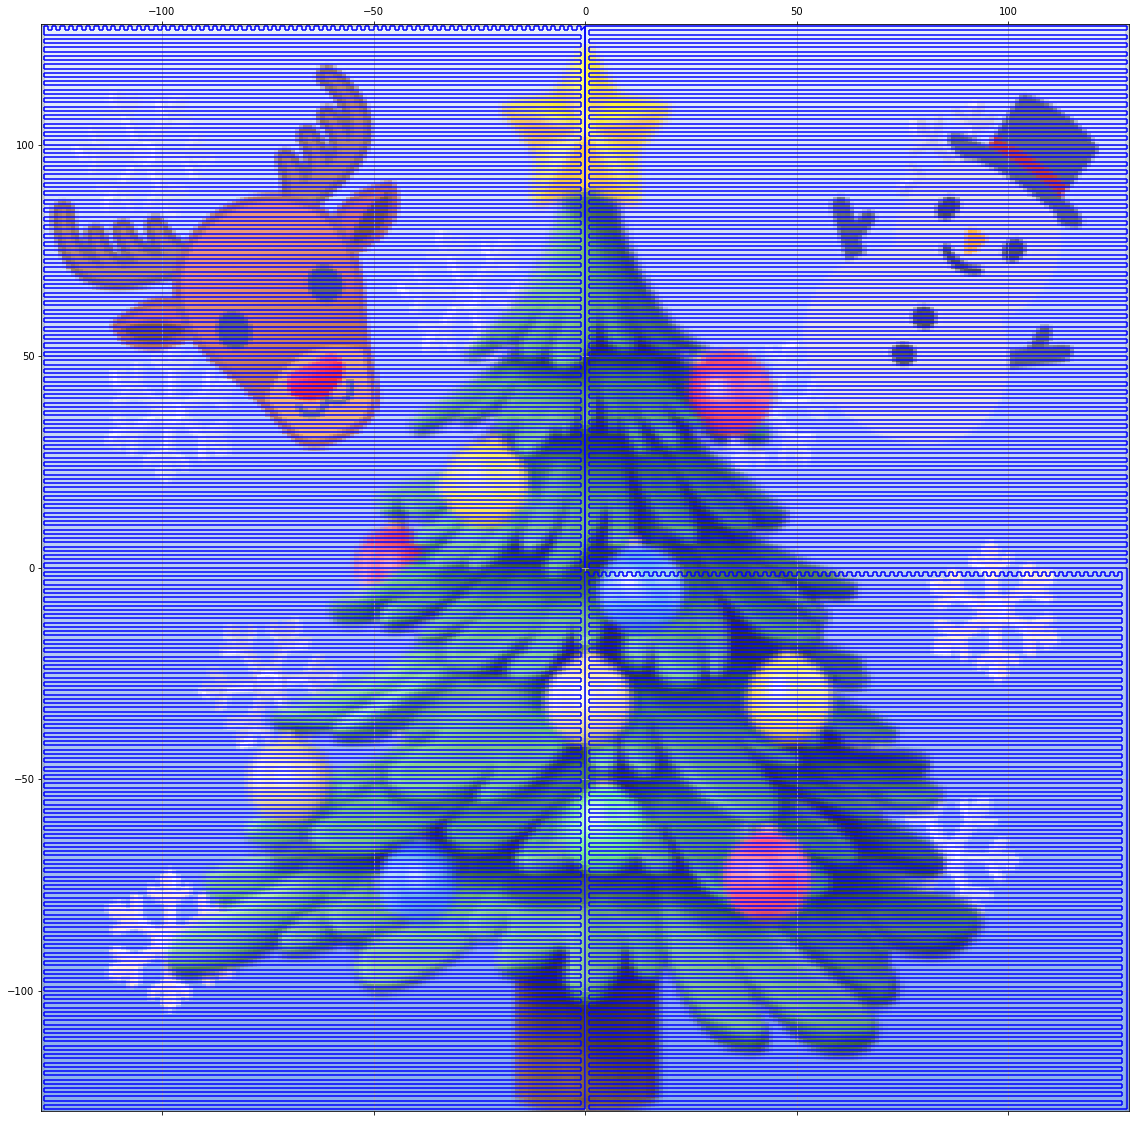

In [10]:
points = get_initial_points()

def plot_traj(points, image_):
    origin = np.array([0, 0])
    lines = []
    if not (origin == points[0]).all():
        lines.append([origin, points[0]])
    for i_ in range(1, len(points)):
        lines.append([points[i_ - 1], points[i_]])
    if not (origin == points[1]).all():
        lines.append([points[-1], origin])

    colors = []
    for l in lines:
        dist = np.abs(l[0] - l[1]).max()
        if dist <= 2:
            colors.append('b')
        else:
            colors.append('r')

    lc = mc.LineCollection(lines, colors=colors)

    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(111)
    ax.add_collection(lc)

    radius = image_.shape[0] // 2
    ax.matshow(image_ * 0.8 + 0.2, extent=(-radius - 0.5, radius + 0.5, -radius - 0.5, radius + 0.5))
    ax.grid(None)

    ax.autoscale()
    fig.show()

    
plot_traj([np.array(p) for p in points], image[:,::-1,:].transpose((1, 0, 2)))

In [11]:
# Helper function to make check-points during the search
def check_point(total_cost, points):
    with io.open('current_solution_data.pkl', 'wb') as out_file:
        pickle.dump({"cost": total_cost, "solution": points}, out_file)

In [12]:
iteration = 0
max_iteration = 10000
check_point_interval = 100
total_cost = sum(step_cost(p0, p1, image) for p0, p1 in zip(points[:-1], points[1:]))
print(total_cost)

start = time.time()
max_time = 60*60*11 + 60*50
# max_time = 60*60
while iteration < max_iteration:
    
    if time.time() - start > max_time:
        break

    iteration += 1
    improved = False

    # points で各ステップのコストを計算し、降順ソートした添字リストをつくる。
    p_cost_index = points_cost_index(points, image)

    # ステップコストが大きい辺から順に近傍操作を行う。
    for i0 in p_cost_index:
        
        i1 = i0 + 1

        # 対応するステップの両端の point を得る。
        point_i0 = points[i0]
        point_i1 = points[i0+1]

        # 対応するステップの両端の近傍を得る。
        point_i0_neighbor = neighbor(point_i0)
        point_i1_neighbor = neighbor(point_i1)

        # 対応するステップの移動先 point の近傍を順にステップコストを計算する。
        for point_j0 in point_i0_neighbor:

            # points 上の point_j0 のインデックスを取得する。
            j0 = points.index(point_j0)

            # points 上でインデックス j0 の対応するステップを得る。
            j1 = j0 + 1
            
            # インデックス j1 に対応する point が存在するなら継続する。
            if j1 >= len(points):
                continue
                
            point_j1 = points[j1]
            
            # point_i1 と point_j1 が近傍関係にあるなら継続する。
            if set(point_j1) not in [set(p) for p in point_i1_neighbor]:
                continue

            # 近傍操作前後のステップコストを計算する。
            c0 = step_cost(point_i0, point_i1, image)
            c1 = step_cost(point_j0, point_j1, image)
            d0 = step_cost(point_i0, point_j0, image)
            d1 = step_cost(point_i1, point_j1, image)
            
            # diff がマイナスなら改善解を意味する。
            diff = (d0 + d1) - (c0 + c1)
            
            # 改善解なら暫定解を更新する。
            if diff < 0:
                improved = True
                if i1 > j1:
                    i1, j1 = j1, i1
                new = points[i1:j1]
                points[i1:j1] = new[::-1]
                total_cost += diff

                print(f'--> Found a better solution at the {iteration}-th iteration;'
                      f' the improvement by transitioning to the better solution was:'
                      f' {diff:.6f}')

                break

        # 改善解が存在するなら point_i0 に対する近傍操作を終える。
        if improved:
            break
            
    # 探索状況を出力する。
    if iteration % 100 == 0:
        print(f'--> {iteration} neighbors have been explored')

    # チェックポイント処理を行う。
    if iteration % check_point_interval == 0:
        print(f'--> Making a check-point of the current best solution with cost: {total_cost:.3f}')
        check_point(total_cost, points)
    
    # 改善解を発見できなかったら近傍操作を終了する。
    if not improved:
        break

# 探索終了状況を出力する。
print(f'Search ended after {max_iteration} iterations;'
      f'  the cost of the new best solution found during the search was: {total_cost:.3f}')

80784.614213559
--> Found a better solution at the 1-th iteration; the improvement by transitioning to the better solution was: -0.042161
--> Found a better solution at the 2-th iteration; the improvement by transitioning to the better solution was: -3.430396
--> Found a better solution at the 3-th iteration; the improvement by transitioning to the better solution was: -6.047059
--> Found a better solution at the 4-th iteration; the improvement by transitioning to the better solution was: -4.376471
--> Found a better solution at the 5-th iteration; the improvement by transitioning to the better solution was: -4.047059
--> Found a better solution at the 6-th iteration; the improvement by transitioning to the better solution was: -0.630396
--> Found a better solution at the 7-th iteration; the improvement by transitioning to the better solution was: -3.035294
--> Found a better solution at the 8-th iteration; the improvement by transitioning to the better solution was: -1.359808
--> Foun

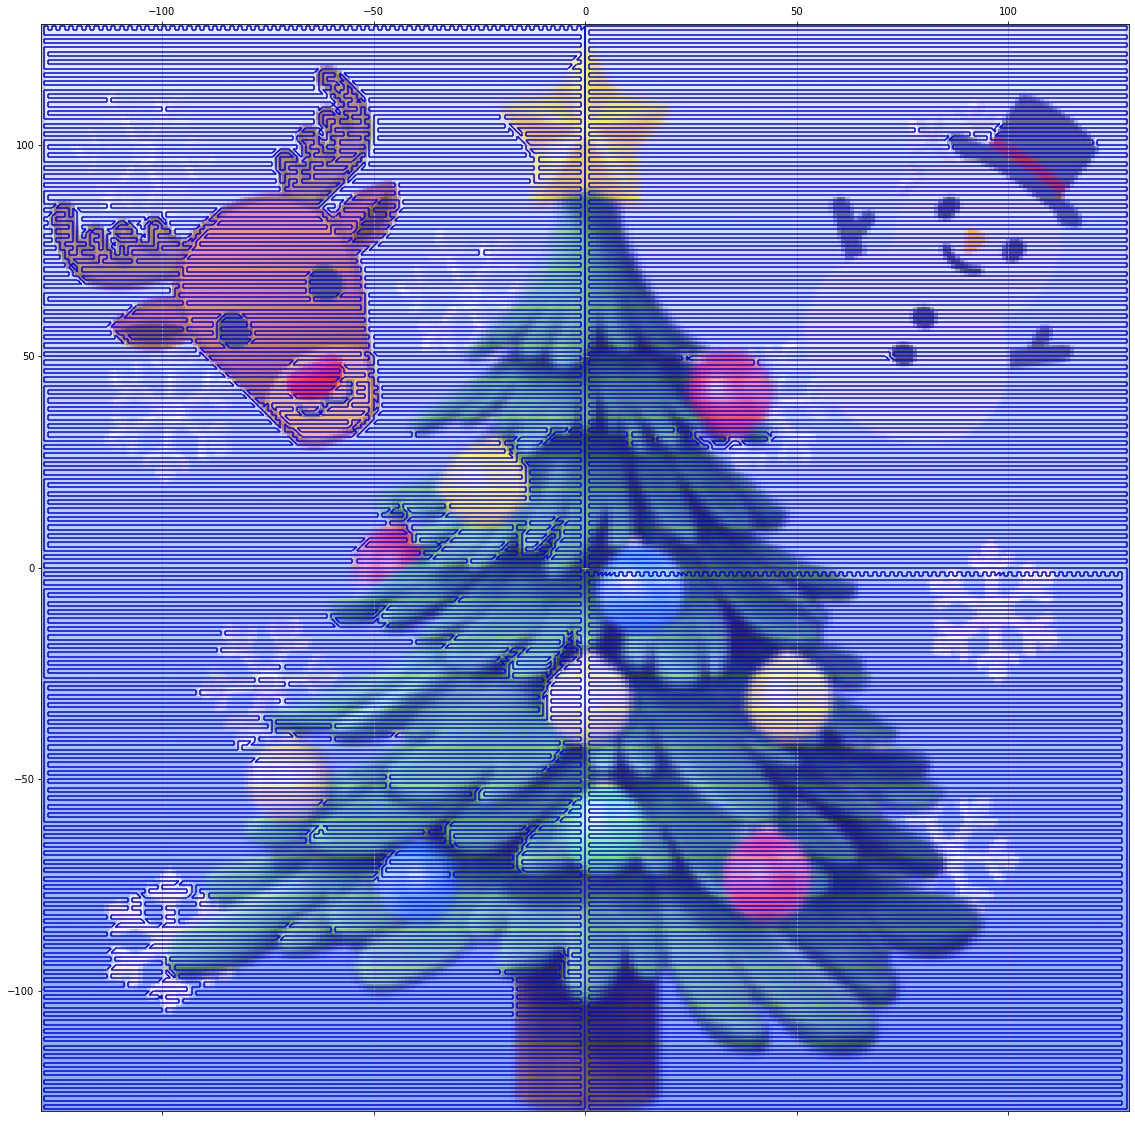

In [13]:
plot_traj([np.array(p) for p in points], image[:,::-1,:].transpose((1, 0, 2)))

In [14]:
total_cost = sum(step_cost(p0, p1, image) for p0, p1 in zip(points[:-1], points[1:]))
print(total_cost)

79529.92190292504


In [15]:
# ファイルを出力する。
config_path = to_configs(points)

# Helper function to convert the path generated from the new best solution into the submission format
def config_to_string(config):
    return ';'.join([' '.join(map(str, vector)) for vector in config])


# Make the submission
submission_opt = pd.Series([config_to_string(config) for config in config_path], name="configuration")
submission_opt.to_csv('submission_optimized.csv', index=False)